## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from neural_networks.unet import UNet
from neural_networks.net_utils import predict_density_maps_and_get_counts
from utils.data.data_generator import DataGenerator
from utils.evaluation.evaluation import evaluation_results_as_dict
from utils.evaluation.evaluation import evaluation_results_as_df
from utils.input_output.io import load_images_and_density_maps
from utils.input_output.io import read_json, write_json
from utils.input_output.io import load_gt_counts
from utils.visualization.vis import plot_some_predictions
from utils.visualization.vis import plot_gt_vs_pred_counts

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

### Select the checkpoint file that you want to test/evaluate

In [4]:
checkpoint_filenames = sorted(os.listdir(config.CHECKPOINTS_PATH))
print(checkpoint_filenames)

['model.01-0.018.hdf5', 'model.02-0.014.hdf5', 'model.03-0.012.hdf5', 'model.04-0.011.hdf5', 'model.05-0.011.hdf5', 'model.06-0.010.hdf5', 'model.07-0.009.hdf5', 'model.08-0.009.hdf5', 'model.09-0.009.hdf5', 'model.10-0.009.hdf5']


In [5]:
selected_checkpoint_filename = checkpoint_filenames[1]
print(f'selected checkpoint_filename: {selected_checkpoint_filename}')

selected checkpoint_filename: model.02-0.014.hdf5


In [6]:
epoch = selected_checkpoint_filename.split('.')[1].split('-')[0]
print('epoch:', epoch)

epoch: 02


In [7]:
# Set epoch and val loss
CHECKPOINT_FILENAME = f'{config.CHECKPOINTS_PATH}/{selected_checkpoint_filename}'
QUANTITATIVE_RESULTS_PATH = f'./{config.SUB_EXPERIMENT_NAME}/results/quantitative/epoch_{epoch}'

In [8]:
!rm -rf $QUANTITATIVE_RESULTS_PATH
os.makedirs(QUANTITATIVE_RESULTS_PATH)

## 2. Load the dataset

In [9]:
params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': False
}

In [10]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **params)
test_generator = DataGenerator(config.DATASET_PATH, 'test', **params)

In [11]:
train_gt_counts = load_gt_counts(config.TRAIN_GT_COUNT_PATH)
val_gt_counts = load_gt_counts(config.VAL_GT_COUNT_PATH)
test_gt_counts = load_gt_counts(config.TEST_GT_COUNT_PATH)

## 3. Load the best model

In [12]:
model = UNet(pretrained_weights=CHECKPOINT_FILENAME)

## 4. Predict and evaluate

In [13]:
train_pred_counts = predict_density_maps_and_get_counts(model, train_generator,
                                                        config.DENSITY_MAP_MULTIPLICATION_FACTOR)
val_pred_counts = predict_density_maps_and_get_counts(model, val_generator,
                                                      config.DENSITY_MAP_MULTIPLICATION_FACTOR)
test_pred_counts = predict_density_maps_and_get_counts(model, test_generator,
                                                       config.DENSITY_MAP_MULTIPLICATION_FACTOR)

In [14]:
train_results = evaluation_results_as_dict(train_gt_counts, train_pred_counts, 'train')
val_results = evaluation_results_as_dict(val_gt_counts, val_pred_counts, 'val')
test_results = evaluation_results_as_dict(test_gt_counts, test_pred_counts, 'test')

df = evaluation_results_as_df(train_results, val_results, test_results,
                              config.ARCHITECTURE_NAME,
                              config.SUB_EXPERIMENT_NAME,
                              config.DATASET_NAME)

df.to_csv(f'{QUANTITATIVE_RESULTS_PATH}/results.csv', index=True)

df.head(3)

MAE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split           
UNet              carpk/sigma_10_loss_logcosh_patch_16_256x256_ep... carpk        train           6.976   
                                                                                  val             6.012   
                                                                                  test           12.607   

                                                                                                   RMSE  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split           
UNet              carpk/sigma_10_loss_logcosh_patch_16_256x256_ep... carpk        train           7.941   
                                                                                  val             7.072   
                                                                                  test           16.477   

                                                                                                Underestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                 
UNet              carpk/sigma_10_loss_logcosh_patch_16_256x256_ep... carpk        train                1.763%   
                                                                                  val                  2.645%   
                                                                                  test                 9.884%   

                                                                                                Overestimate  \
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split                
UNet              carpk/sigma_10_loss_logcosh_patch_16_256x256_ep... carpk        train              14.637%   
                                                                                  val                10.762%   
                                                                                  test                2.299%   

                                                                                                Difference  
Architecture_Name Experiment_Name                                    Dataset_Name Dataset_Split             
UNet              carpk/sigma_10_loss_logcosh_patch_16_256x256_ep... carpk        train            16.400%  
                                                                                  val              13.406%  
                                                                                  test             12.183%

## 5. Short analysis of evaluation results

carpk dataset

train set: 900 images
Underestimation in 130 images
Overestimation in 770 images
(GT stats)         counts per image: mean=42.54, std=14.82, min=1,    max=87
(Prediction stats) counts per image: mean=48.01, std=15.05, min=8.30, max=94.77

test set: 459 images
Underestimation in 310 images
Overestimation in 149 images
(GT stats)         counts per image: mean=103.48, std=39.14, min=2,    max=188
(Prediction stats) counts per image: mean=95.63, std=32.19, min=8.90, max=153.63


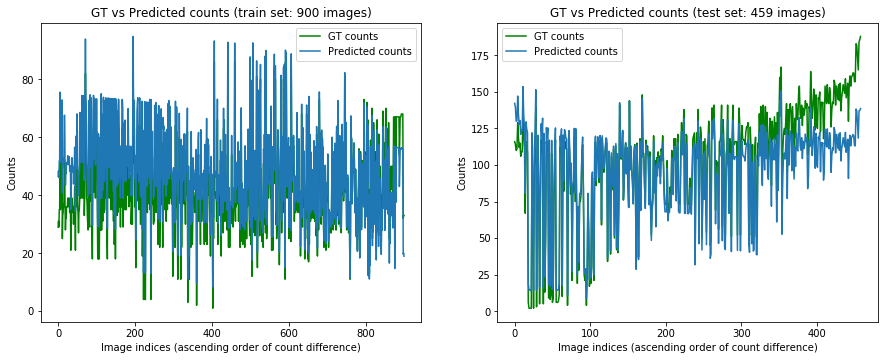

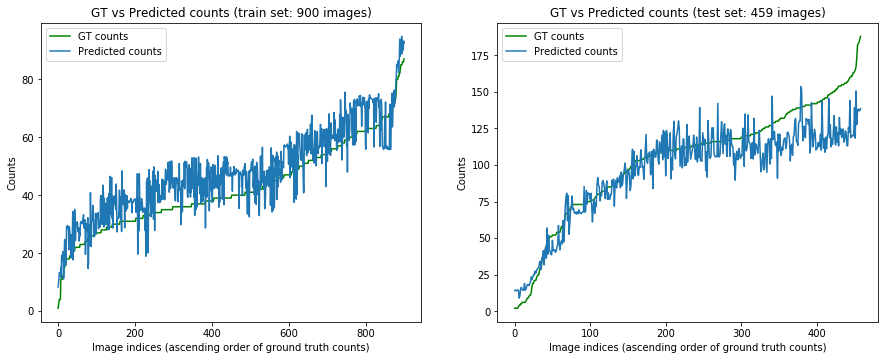

In [15]:
print(f'{config.DATASET_NAME} dataset')

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False)

plt.figure(figsize=(15, 5.5))
plt.subplot(1, 2, 1)
plot_gt_vs_pred_counts(train_gt_counts, train_pred_counts, 'train', new_figure=False,
                       criterion='gt', print_stats=False)
plt.subplot(1, 2, 2)
plot_gt_vs_pred_counts(test_gt_counts, test_pred_counts, 'test', new_figure=False,
                       criterion='gt', print_stats=False)

## 6. Look at some predictions (a small batch from the test set)

In [16]:
NUM_IMAGES = 3
test_images_batch, test_density_maps_batch = load_images_and_density_maps(config.TEST_PATH, NUM_IMAGES)
test_preds_batch = model.predict(np.array(test_images_batch)) / config.DENSITY_MAP_MULTIPLICATION_FACTOR

def small_desc(images_batch, title):
    print(title)
    print(len(images_batch),
          images_batch[0].shape, images_batch[0].dtype,
          images_batch[0].min(), images_batch[0].max())
    print()
    
small_desc(test_images_batch, 'test_images_batch')
small_desc(test_density_maps_batch, 'test_density_maps_batch')
small_desc(test_preds_batch, 'test_preds_batch')

test_images_batch
3 (720, 1280, 3) float64 0.0 1.0

test_density_maps_batch
3 (720, 1280) float64 0.0 0.0028073483693418734

test_preds_batch
3 (720, 1280, 1) float32 -0.00012763019 0.0022320666



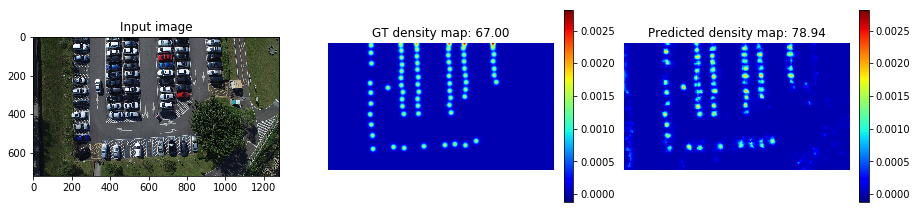

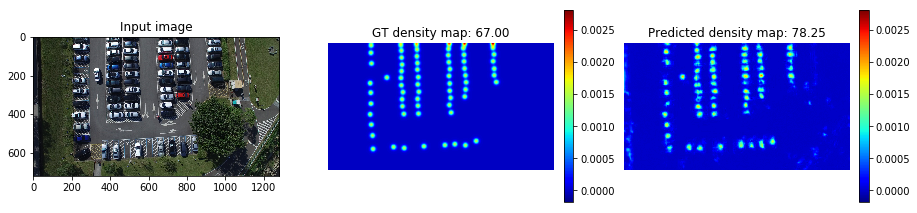

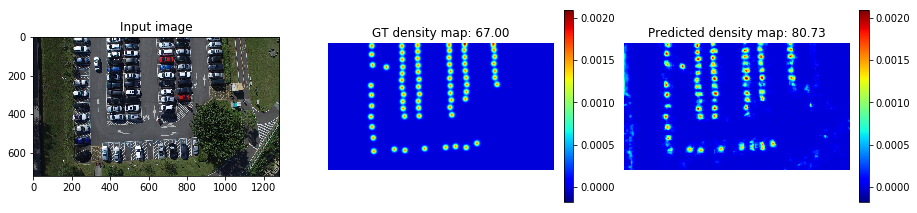

In [17]:
plot_some_predictions(test_images_batch, test_density_maps_batch, test_preds_batch)

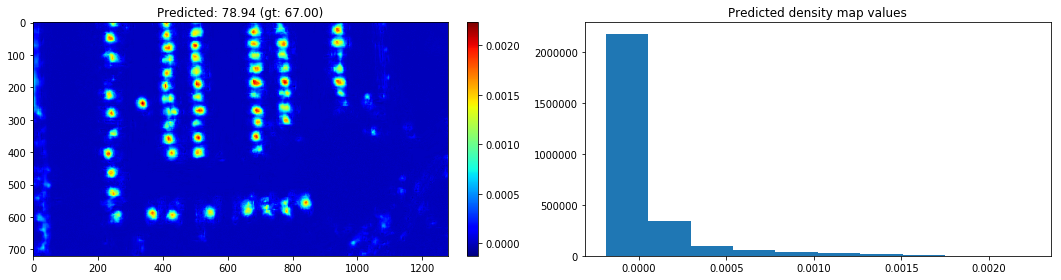

In [18]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.title(f'Predicted: {test_preds_batch[0].sum():.2f} (gt: {test_density_maps_batch[0].sum():.2f})')
plt.imshow(test_preds_batch.squeeze()[0], cmap='jet')
plt.colorbar(fraction=0.045, pad=0.04)
plt.subplot(1, 2, 2)
plt.title('Predicted density map values')
plt.hist(test_preds_batch.flatten())
plt.tight_layout()
plt.show()